# Post-analyze

For better interpretation of results.

**Make sure to run analyze.py, grade_label.py (or label/run_parallel.sh), compare_with_label.py in advance.**

We consider the converted molecular graph is chemically valid (or *ChemVal* shortly, hereinafter) if

- the total charge of the molecular graph is identical to the value passed as input
- none of atoms have odd number of electrons (no unpaired electron)
- RDKit `Chem.SanitizeMol` does not raise error

We consider the converted molecular graph is the most chemically stable (or *ChemStab* shortly, hereinafter) if

- the number of atoms satisfying the octet rule is the most.
- the formal charge separation is the least.
- the number of atoms participating in conjugate (aromatic) system is the most.

## Modules

In [1]:
import os.path as osp
import pathlib
import pickle
import pandas as pd
import numpy as np
import subprocess
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage
from rdkit.Chem import Draw
MOLSIZE=(500,500)
IPythonConsole.drawOptions.addAtomIndices = True
IPythonConsole.drawOptions.includeRadicals = True
IPythonConsole.molSize = MOLSIZE

In [2]:
from convert import main_charge, indigox_charge, xyz2mol_charge, obabel_charge
from grade_noAns import check_noRadical

## Setups

In [3]:
DAT = pathlib.Path.cwd() / "DATA" / "PubChemQC"
XYZ = DAT / "neutral"
EXP = pathlib.Path.cwd() / "PubChemQC" / "exp250227" # path/to/experiment/directory

## DATA Loading

In [4]:
_OBB_PKL = "df_obabel.pkl"
_IGX_PKL = "df_indigox.pkl"
_X2M_PKL = "df_xyz2mol.pkl"
_BOS_PKL = "df_bos.pkl"
_ANA_PKL = "df_ana.pkl"

In [5]:
OBB_PKL = EXP / _OBB_PKL
IGX_PKL = EXP / _IGX_PKL
X2M_PKL = EXP / _X2M_PKL
BOS_PKL = EXP / _BOS_PKL
ANA_PKL = EXP / _ANA_PKL
TIMEFIG = EXP / "time.png"
VS_LAB = EXP / "vs_label.csv"
LAB = DAT / "name_chg_smi_neutral_sel.woRadical250227"

In [6]:
with open(ANA_PKL, "rb") as f:
    ana = pickle.load(f)
    ana.drop(ana[ana["name"].str.contains("Valence")].index, inplace=True)
#ana=ana.loc[:,~ana.columns.duplicated()]
ana

/tmp/ipykernel_4297/1500374740.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  ana = pickle.load(f)


,name,chg_obb,ChemVal_obb,ChgConserve_obb,NoRadical_obb,Sanitize_obb,ChemStab_obb,BOSum_obb,ChgSepa_obb,nAromatic_obb,...,chg_lab,ChemVal_lab,ChgConserve_lab,NoRadical_lab,Sanitize_lab,ChemStab_lab,BOSum_lab,ChgSepa_lab,nAromatic_lab,nOctet_lab
0,1.xyz,0,2,1,1,0,<NA>,<NA>,<NA>,<NA>,...,0,3,1,1,1,30,32,2,0,31
1,10.xyz,0,3,1,1,1,81,69,0,12,...,0,3,1,1,1,81,69,0,12,57
2,1000.xyz,0,3,1,1,1,30,24,0,6,...,0,3,1,1,1,30,24,0,6,21
3,10000.xyz,0,3,1,1,1,10,10,0,0,...,0,3,1,1,1,10,10,0,0,10
4,100001.xyz,0,3,1,1,1,51,40,0,11,...,0,3,1,1,1,51,40,0,11,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,9999.xyz,0,3,1,1,1,7,7,0,0,...,0,3,1,1,1,7,7,0,0,4
99996,99993.xyz,0,3,1,1,1,43,37,0,6,...,0,3,1,1,1,43,37,0,6,34
99997,99994.xyz,0,3,1,1,1,43,37,0,6,...,0,3,1,1,1,43,37,0,6,32
99998,99995.xyz,0,3,1,1,1,34,34,0,0,...,0,3,1,1,1,34,34,0,0,30


In [7]:
with open(BOS_PKL, "rb") as f:
    bos = pickle.load(f)
bos = bos.loc[:,~bos.columns.duplicated()]
bos

/tmp/ipykernel_4297/1025468744.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  bos = pickle.load(f)


,name,chg,ChgConserve,NoRadical,Sanitize,BOSum,ChgSepa,nAromatic,nOctet,time,ChemVal,ChemStab
0,102154.xyz,0,1.0,1.0,1.0,22.0,0.0,0.0,21.0,0.06059,3.0,22.0
1,209859.xyz,0,1.0,1.0,1.0,22.0,0.0,0.0,19.0,0.10620,3.0,22.0
2,73826.xyz,0,1.0,1.0,1.0,30.0,0.0,6.0,25.0,0.19188,3.0,36.0
3,78967.xyz,0,1.0,1.0,1.0,9.0,0.0,0.0,9.0,0.03996,3.0,9.0
4,90837.xyz,0,1.0,1.0,1.0,92.0,0.0,0.0,92.0,0.17126,3.0,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,15130.xyz,0,1.0,1.0,1.0,65.0,0.0,12.0,57.0,0.37716,3.0,77.0
99996,55525.xyz,0,1.0,1.0,1.0,50.0,0.0,6.0,44.0,0.24274,3.0,56.0
99997,169038.xyz,0,1.0,1.0,1.0,59.0,0.0,0.0,60.0,0.17493,3.0,59.0
99998,7979.xyz,0,1.0,1.0,1.0,45.0,0.0,0.0,42.0,0.09308,3.0,45.0


In [8]:
with open(OBB_PKL, "rb") as f:
    obb = pickle.load(f)
obb

/tmp/ipykernel_4297/2963333945.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  obb = pickle.load(f)


,name,chg,ChgConserve,NoRadical,Sanitize,BOSum,ChgSepa,nAromatic,nOctet,time,ChemVal,ChemStab
0,78967.xyz,0,1,1,1,9,0,0,9,0.00007,3,9
1,90837.xyz,0,1,1,1,92,0,0,92,0.00008,3,92
2,73826.xyz,0,1,1,1,30,0,6,25,0.00007,3,36
3,72164.xyz,0,1,1,1,68,0,23,54,0.00015,3,91
4,102154.xyz,0,1,1,0,22,0,0,20,0.00004,2,22
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,256804.xyz,0,1,1,0,45,0,0,36,0.00009,2,45
99996,55525.xyz,0,1,1,1,50,0,6,44,0.00009,3,56
99997,7979.xyz,0,1,1,1,45,0,0,42,0.00009,3,45
99998,169038.xyz,0,1,1,1,59,0,0,60,0.00011,3,59


In [9]:
with open(IGX_PKL, "rb") as f:
    igx = pickle.load(f)
igx

/tmp/ipykernel_4297/325004882.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  igx = pickle.load(f)


,name,chg,ChgConserve,NoRadical,Sanitize,BOSum,ChgSepa,nAromatic,nOctet,time,ChemVal,ChemStab
0,201671.xyz,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,73826.xyz,0,1.0,1.0,1.0,30.0,0.0,6.0,25.0,0.10545,3.0,36.0
2,90837.xyz,0,1.0,1.0,1.0,92.0,0.0,0.0,92.0,0.02700,3.0,92.0
3,102154.xyz,0,1.0,1.0,1.0,22.0,0.0,0.0,21.0,0.02224,3.0,22.0
4,209859.xyz,0,1.0,1.0,1.0,22.0,0.0,0.0,19.0,0.01937,3.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99855,21124.xyz,0,1.0,1.0,1.0,38.0,0.0,15.0,28.0,0.14234,3.0,53.0
99856,169038.xyz,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99857,55525.xyz,0,1.0,1.0,1.0,50.0,0.0,6.0,44.0,0.01367,3.0,56.0
99858,7979.xyz,0,1.0,1.0,1.0,45.0,0.0,0.0,42.0,0.00362,3.0,45.0


In [10]:
with open(X2M_PKL, "rb") as f:
    x2m = pickle.load(f)
x2m    

/tmp/ipykernel_4297/1370497150.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  x2m = pickle.load(f)


,name,chg,ChgConserve,NoRadical,Sanitize,BOSum,ChgSepa,nAromatic,nOctet,time,ChemVal,ChemStab
0,102154.xyz,0,1.0,1.0,1.0,22.0,0.0,0.0,21.0,0.02554,3.0,22.0
1,103840.xyz,0,1.0,1.0,1.0,42.0,0.0,6.0,34.0,0.02658,3.0,48.0
2,78967.xyz,0,1.0,1.0,1.0,9.0,0.0,0.0,9.0,0.00183,3.0,9.0
3,73826.xyz,0,1.0,1.0,1.0,30.0,0.0,6.0,25.0,0.02444,3.0,36.0
4,209859.xyz,0,1.0,1.0,1.0,22.0,0.0,0.0,19.0,0.03401,3.0,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99032,256804.xyz,0,1.0,1.0,1.0,44.0,0.0,0.0,38.0,0.00744,3.0,44.0
99033,55525.xyz,0,1.0,1.0,1.0,50.0,0.0,6.0,44.0,0.01146,3.0,56.0
99034,7979.xyz,0,1.0,1.0,1.0,45.0,0.0,0.0,42.0,0.00747,3.0,45.0
99035,169038.xyz,0,1.0,1.0,1.0,59.0,0.0,0.0,60.0,0.04007,3.0,59.0


In [11]:
chemstab_pkl = osp.join(EXP, "chemstab_res.pkl")
with open(chemstab_pkl, "rb") as f:
    chemstab_res = pickle.load(f)
chemstab_idx_name = chemstab_res.iloc[-1]
chemstab_res = chemstab_res.iloc[:-1]
chemstab_res

0                IGX,X2M
1        OBB,IGX,X2M,BOS
2        OBB,IGX,X2M,BOS
3        OBB,IGX,X2M,BOS
4        OBB,IGX,X2M,BOS
              ...       
99995    OBB,IGX,X2M,BOS
99996    OBB,IGX,X2M,BOS
99997    OBB,IGX,X2M,BOS
99998    OBB,IGX,X2M,BOS
99999    OBB,IGX,X2M,BOS
Length: 100000, dtype: object

In [12]:
chemstab_idx_name

0             1.xyz
1            10.xyz
2          1000.xyz
3         10000.xyz
4        100001.xyz
            ...    
99995      9999.xyz
99996     99993.xyz
99997     99994.xyz
99998     99995.xyz
99999     99999.xyz
Name: name, Length: 100000, dtype: object

In [13]:
vs_lab = pd.read_csv(VS_LAB, index_col=0)

## Time Cost Comparison

Openbabel works the fastest, and BOSolver requires the longest time to perceive bonds.

But empirically, the worst-case time cost of BOSolver is quite modest, while IndigoX and xyz2mol show poor time efficiency for their worst-cases.

- Note: OBB-Openbabel, IGX-IndigoX, X2M-xyz2mol, BOS-BOSolver

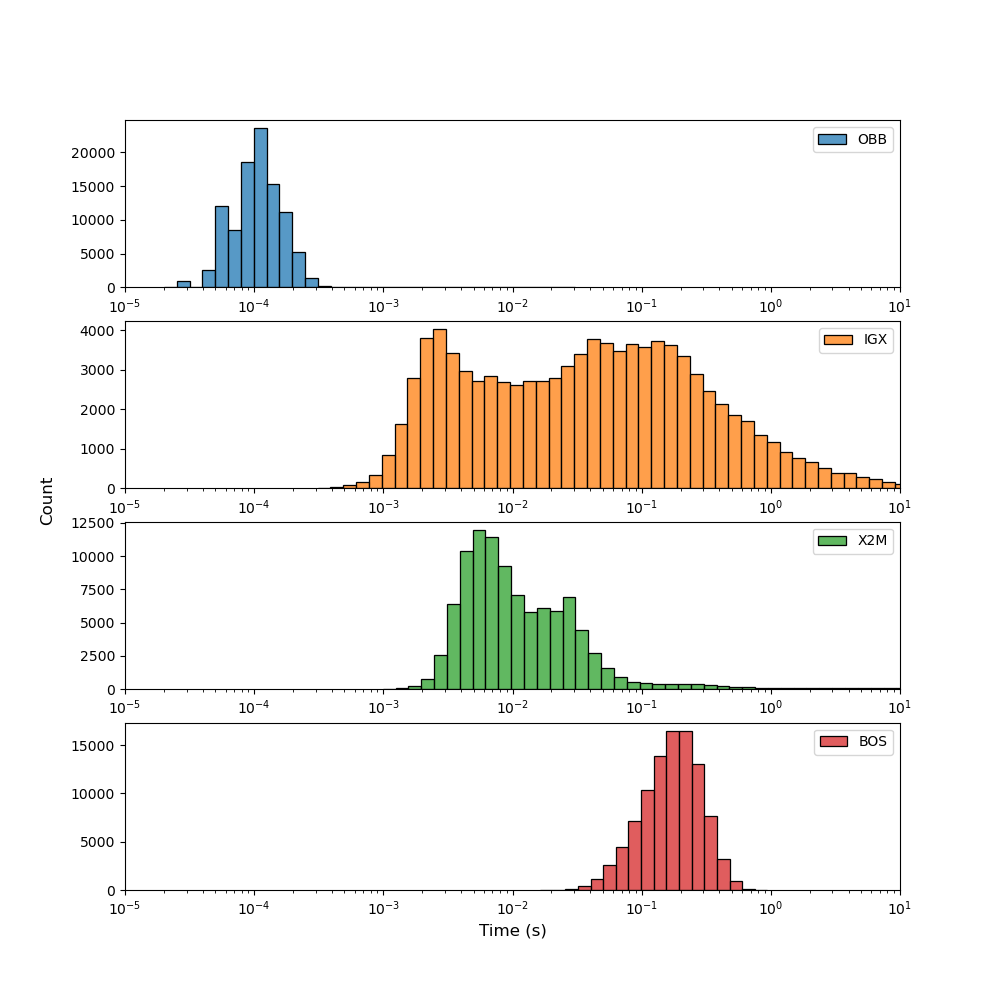

In [14]:
from IPython.display import Image, display
display(Image(TIMEFIG))

## Post-analysis

In [15]:
def do_stuff(mol, removeHs=False):
    Chem.RemoveStereochemistry(mol)
    rdDepictor.Compute2DCoords(mol)
    #rdDepictor.StraightenDepiction(mol)
    if removeHs:
        mol = Chem.RemoveHs(mol, sanitize=False)
    return mol

def show_label_and_four(obb, igx, x2m, bos, label, removeHs=False):
    if isinstance(label, Chem.Mol):
        label = do_stuff(label, removeHs=removeHs)
    else:
        label = Chem.Mol()
    if isinstance(obb, Chem.Mol):
        obb = do_stuff(obb, removeHs=removeHs)
    else:
        obb = Chem.Mol()
    if isinstance(igx, Chem.Mol):
        igx = do_stuff(igx, removeHs=removeHs)
    else:
        igx = Chem.Mol()
    if isinstance(x2m, Chem.Mol):
        x2m = do_stuff(x2m, removeHs=removeHs)
    else:
        x2m = Chem.Mol()
    if isinstance(bos, Chem.Mol):
        bos = do_stuff(bos, removeHs=removeHs)
    else:
        bos = Chem.Mol()
    return Draw.MolsToGridImage([obb, igx, x2m, bos, label], molsPerRow=2, subImgSize=MOLSIZE, legends=["OBB", "IGX", "X2M", "BOS", "Label"])

### Items that only BOSolver succeeded to convert

In [16]:
bos_only = chemstab_idx_name[chemstab_res[chemstab_res == "BOS"].index] # 257 items
print("examples:", bos_only.head().values.tolist())

examples: ['10112.xyz', '103417.xyz', '103884.xyz', '105409.xyz', '105808.xyz']


Visualizing 103884.xyz

The only acceptable structure is that converted by BOSolver.

- Openbabel tends to leave all atoms' formal charge to zero, resulting in unpaired electrons. (here Cl, atom index 23, is not HCl, but radical. RDKit draws all radicals such way.)
- IndigoX only works for one component (all atoms should be connected as a single graph.)
- xyz2mol tends to give excessive charge separation. Based on observation, this usually happens when there is big conjugate system (resonance).

Error (103884.xyz, 0): conversion failedElectrons can only be assigned when molecule has only one component.



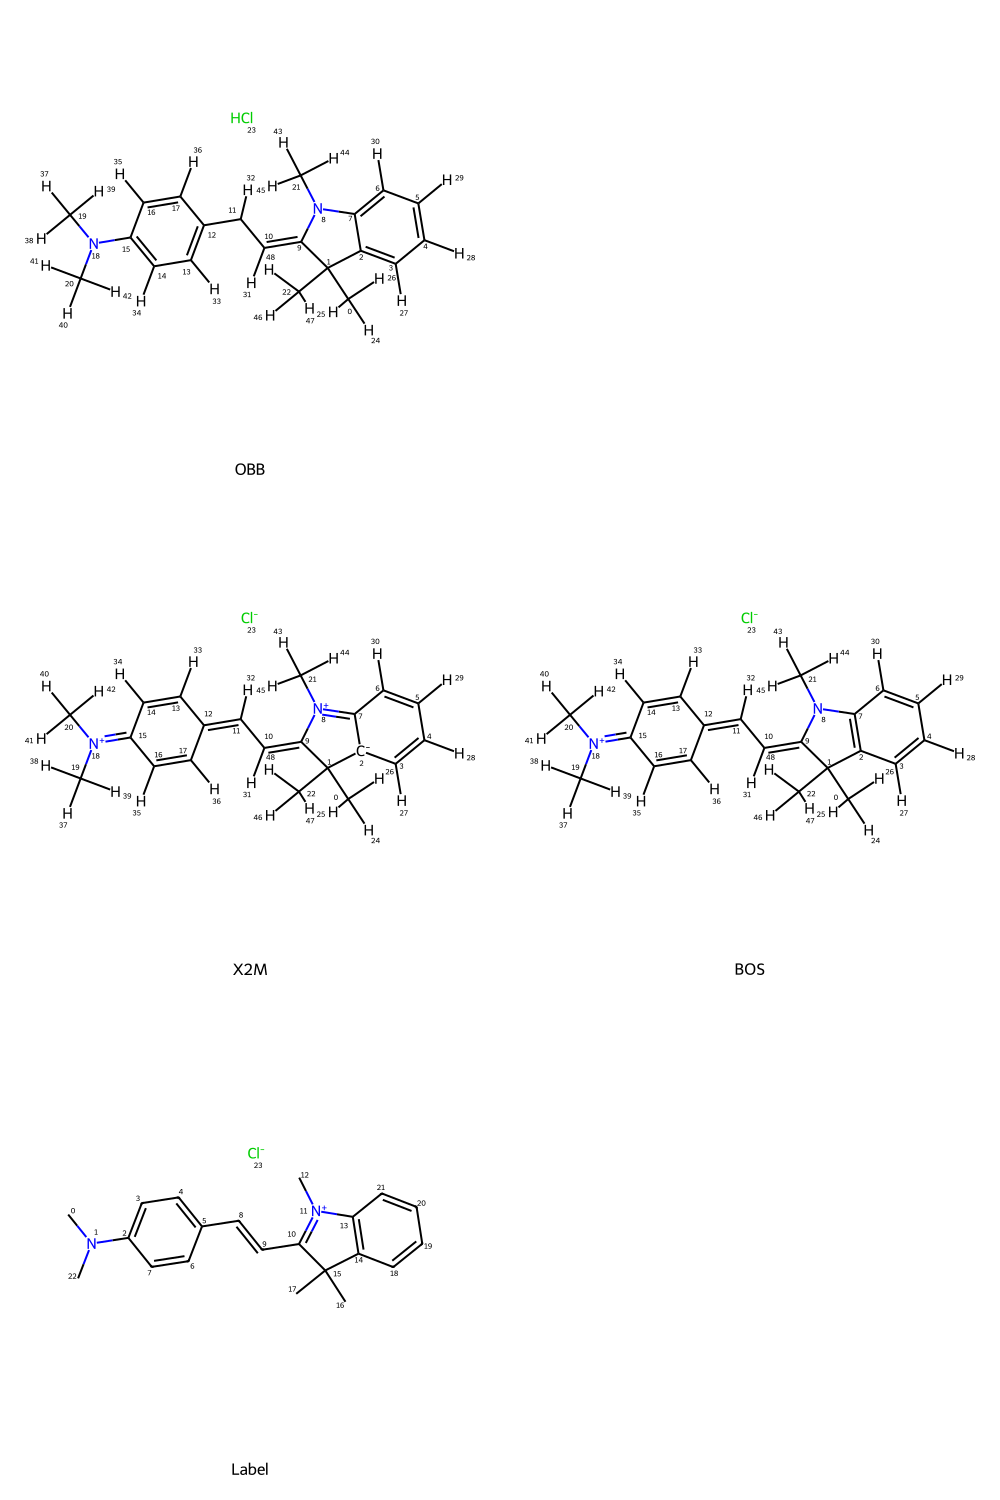

BOS failed: 1437
examples: ['1.xyz', '100289.xyz', '100367.xyz', '100368.xyz', '100848.xyz']
BOS failed but converted: 2
examples: ['49391.xyz', '71589.xyz']
EXAMPLES ( total: 235 )

nOctet fail: 117
examples ['101098.xyz', '106072.xyz', '107336.xyz', '108575.xyz', '108762.xyz']

chgSepa fail: 81
examples ['101601.xyz', '101830.xyz', '101955.xyz', '104483.xyz', '105348.xyz']

BOSum fail: 0
examples []

nAromatic fail: 37
examples ['108569.xyz', '113002.xyz', '11960.xyz', '123194.xyz', '128114.xyz']
all failed: 604
examples: ['100848.xyz', '101569.xyz', '101827.xyz', '101847.xyz', '103099.xyz']


In [17]:
xyzname = '103884.xyz'
xyzfile = XYZ / xyzname
emp_obb, _ = obabel_charge(str(xyzfile.absolute()), 0)
emp_igx, _ = indigox_charge(str(xyzfile.absolute()), 0) # conversion failed
emp_x2m, _ = xyz2mol_charge(str(xyzfile.absolute()), 0)
emp_bos, _ = main_charge(str(xyzfile.absolute()), 0)
smi = subprocess.check_output(f"grep '/{xyzname}' '{LAB}' | cut -d' ' -f3", shell=True).decode().strip().strip('"')
emp_lab = Chem.MolFromSmiles(smi)

show_label_and_four(emp_obb, emp_igx, emp_x2m, emp_bos, emp_lab)

### Items that BOSolver failed to convert into *ChemVal* molecular graphs

In [18]:
bos_fail = ana[(ana["ChemVal_bos"] < 3) | ana["ChemVal_bos"].isna()]
bos_fail_but_converted = ana[ana["ChemVal_bos"] < 3]
print("BOS failed:", bos_fail.shape[0])
print("examples:" , bos_fail["name"].head().values.tolist())
print("BOS failed but converted:", bos_fail_but_converted.shape[0])
print("examples:" , bos_fail_but_converted["name"].head().values.tolist())

### Items that BOSolver did not converted in to the most *ChemStab* molecular graph (chemical structure) among four methods.

In [19]:
nostab = chemstab_idx_name[chemstab_res[~chemstab_res.str.contains("BOS")].index]
nostab_ChemVal_bos = ana.loc[ana["name"].isin(nostab), ["ChemVal_bos"]]

# only choose items that were converted without error (chemically valid), 
# but failed to find the most chemically stable molecular graph (235 items)
unsuccessful = ana.iloc[nostab_ChemVal_bos[nostab_ChemVal_bos["ChemVal_bos"]==3].index]

# items that nOctet is not the highest in BOS (117 items)
nOctet = unsuccessful[unsuccessful["nOctet_bos"] != unsuccessful[["nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_bos"]].max(axis=1)
                      ][["name", "nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_bos"]]

# items that Charge Separation is not the smallest in BOS (81 items)
chgSepa = unsuccessful[(unsuccessful["nOctet_bos"] == unsuccessful[["nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_bos"]].max(axis=1))
                       & (unsuccessful["ChgSepa_bos"] != unsuccessful[["ChgSepa_obb", "ChgSepa_igx", "ChgSepa_x2m", "ChgSepa_bos"]].min(axis=1))
                       ][["name", "ChgSepa_obb", "ChgSepa_igx", "ChgSepa_x2m", "ChgSepa_bos"]]


# items that Bond Order Sum is not the greatest in BOS (0 items)
BOSum = unsuccessful[(unsuccessful["nOctet_bos"] == unsuccessful[["nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_bos"]].max(axis=1))
                       & (unsuccessful["ChgSepa_bos"] == unsuccessful[["ChgSepa_obb", "ChgSepa_igx", "ChgSepa_x2m", "ChgSepa_bos"]].min(axis=1))
                       & (unsuccessful["BOSum_bos"] != unsuccessful[["BOSum_obb", "BOSum_igx", "BOSum_x2m", "BOSum_bos"]].max(axis=1))
                       ][["name", "BOSum_obb", "BOSum_igx", "BOSum_x2m", "BOSum_bos"]]

# items that nAromatic is not the highest in BOS (37 items)
# since BOSolver cannot handle aromaticity, we will not consider this
nAro = unsuccessful[(unsuccessful["nOctet_bos"] == unsuccessful[["nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_bos"]].max(axis=1))
                       & (unsuccessful["ChgSepa_bos"] == unsuccessful[["ChgSepa_obb", "ChgSepa_igx", "ChgSepa_x2m", "ChgSepa_bos"]].min(axis=1))
                       & (unsuccessful["BOSum_bos"] == unsuccessful[["BOSum_obb", "BOSum_igx", "BOSum_x2m", "BOSum_bos"]].max(axis=1))
                       & (unsuccessful["nAromatic_bos"] != unsuccessful[["nAromatic_obb", "nAromatic_igx", "nAromatic_x2m", "nAromatic_bos"]].max(axis=1))
                       ][["name", "nAromatic_obb", "nAromatic_igx", "nAromatic_x2m", "nAromatic_bos"]]

print("EXAMPLES", "(", "total:", unsuccessful.shape[0], ")")
print()
print("nOctet fail:", nOctet.shape[0])
print("examples", nOctet["name"].head().values.tolist())
print()
print("chgSepa fail:", chgSepa.shape[0])
print("examples", chgSepa["name"].head().values.tolist())
print()
print("BOSum fail:", BOSum.shape[0])
print("examples", BOSum["name"].head().values.tolist())
print()
print("nAromatic fail:", nAro.shape[0])
print("examples", nAro["name"].head().values.tolist())

### Items that all four methods had failed to convert.

In [20]:
obb_check = (ana["ChemVal_obb"] != 3).fillna(True)
igx_check = (ana["ChemVal_igx"] != 3).fillna(True)
x2m_check = (ana["ChemVal_x2m"] != 3).fillna(True)
bos_check = (ana["ChemVal_bos"] != 3).fillna(True)
all_fail = ana[obb_check & igx_check & x2m_check & bos_check]
print("all failed:", all_fail.shape[0])
print("examples:", all_fail["name"].head().values.tolist())

visualizing 100848.xyz

Error (100848.xyz, 0): conversion failedElectrons can only be assigned when molecule has only one component.



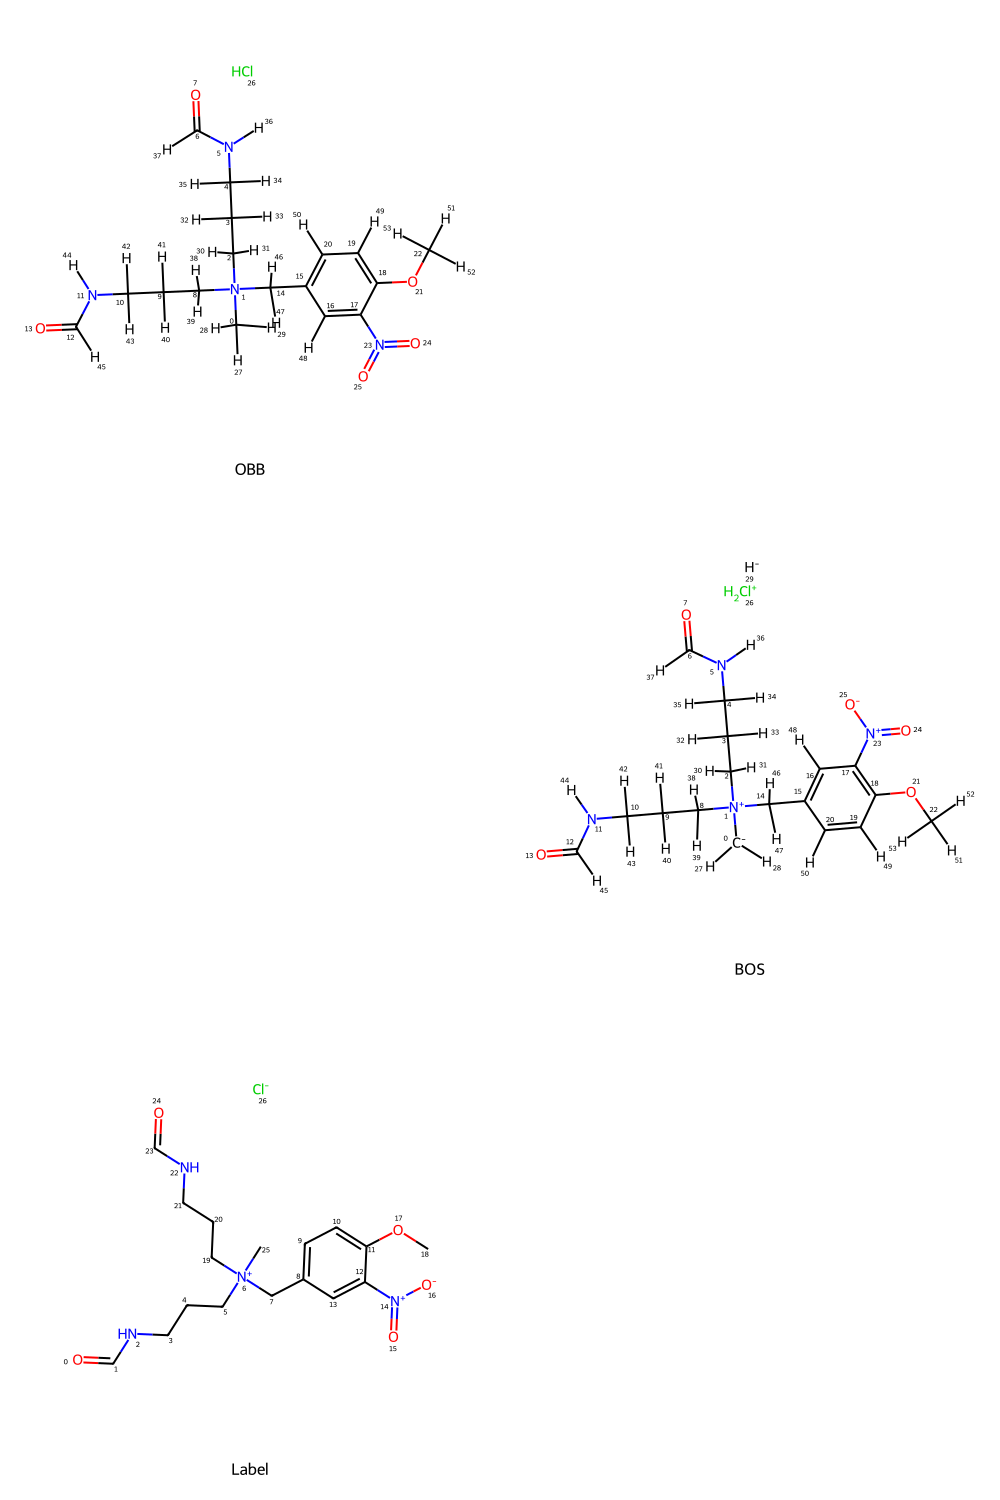

In [21]:
xyzname = '100848.xyz'
xyzfile = XYZ / xyzname
emp_obb, _ = obabel_charge(str(xyzfile.absolute()), 0)
emp_igx, _ = indigox_charge(str(xyzfile.absolute()), 0)
#emp_x2m, _ = xyz2mol_charge(str(xyzfile.absolute()), 0) # timeout
emp_x2m = None
emp_bos, _ = main_charge(str(xyzfile.absolute()), 0) # problem in connectivity perception; see the next cell
smi = subprocess.check_output(f"grep '/{xyzname}' '{LAB}' | cut -d' ' -f3", shell=True).decode().strip().strip('"')
emp_lab = Chem.MolFromSmiles(smi)

show_label_and_four(emp_obb, emp_igx, emp_x2m, emp_bos, emp_lab, removeHs=False)

BOSolver result with different connectivity information.

This example shows the importance of giving the correct connectivity.

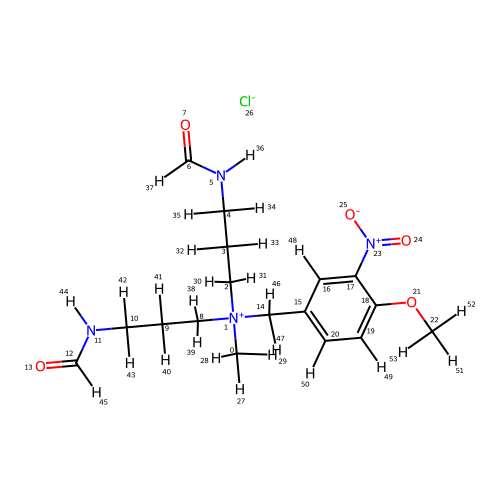

In [22]:
from BOSolver import bosolve

emp_bos2 = Chem.MolFromXYZFile(str(xyzfile.absolute()))
algo = bosolve.CovalentRadius(relTol=1.2, absTol=0.0) # relTol=1.15 for the experiment

emp_bos2 = bosolve.perceiveConn(emp_bos2, algo)
emp_bos2 = bosolve.assignBO(emp_bos2, 0) # now it works
do_stuff(emp_bos2) 

## Other Examples

In [23]:
def show_good_and_bad(good, bad):
    Chem.RemoveStereochemistry(good); Chem.RemoveStereochemistry(bad)
    rdDepictor.Compute2DCoords(good); rdDepictor.Compute2DCoords(bad);
    rdDepictor.StraightenDepection(good); rdDepictor.StraightenDepection(bad);
    Draw.MolsToGridImage([good, bad], molsPerRow=2, subImgSize=(500,500), labels=["good (BOSolver)", "bad"])

### Bad xyz2mol Examples

xyz2mol occasionally creates overly charge-separated molecular graph.

In [24]:
nostab_x2m = chemstab_idx_name[chemstab_res[~chemstab_res.str.contains("X2M")].index]
nostab_ChemVal_x2m = ana.loc[ana["name"].isin(nostab), ["ChemVal_x2m"]]

# only choose items that were converted without error (chemically valid), 
# but failed to find the most chemically stable molecular graph (235 items)
uns_x2m = ana.iloc[nostab_ChemVal_x2m[nostab_ChemVal_x2m["ChemVal_x2m"] == 3].index]
#chgSepa_x2m = uns_x2m[(uns_x2m["nOctet_x2m"] == uns_x2m[["nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_bos"]].max(axis=1))
#                       & (unsuccessful["ChgSepa_x2m"] != unsuccessful[["ChgSepa_obb", "ChgSepa_igx", "ChgSepa_x2m", "ChgSepa_bos"]].min(axis=1))
#                       ][["name", "ChgSepa_obb", "ChgSepa_igx", "ChgSepa_x2m", "ChgSepa_bos"]]
chgSepa_x2m = uns_x2m[(uns_x2m["nOctet_x2m"] == uns_x2m[["nOctet_obb", "nOctet_igx", "nOctet_x2m", "nOctet_bos"]].max(axis=1))
                       & (uns_x2m["ChgSepa_x2m"] > uns_x2m["ChgSepa_bos"])
                       ][["name", "ChgSepa_obb", "ChgSepa_igx", "ChgSepa_x2m", "ChgSepa_bos"]]
chgSepa_x2m

,name,ChgSepa_obb,ChgSepa_igx,ChgSepa_x2m,ChgSepa_bos
84314,59810.xyz,<NA>,<NA>,4,2


visualizing 59810.xyz

Error (59810.xyz, 0): conversion failed
Electrons can only be assigned when molecule has only one component.


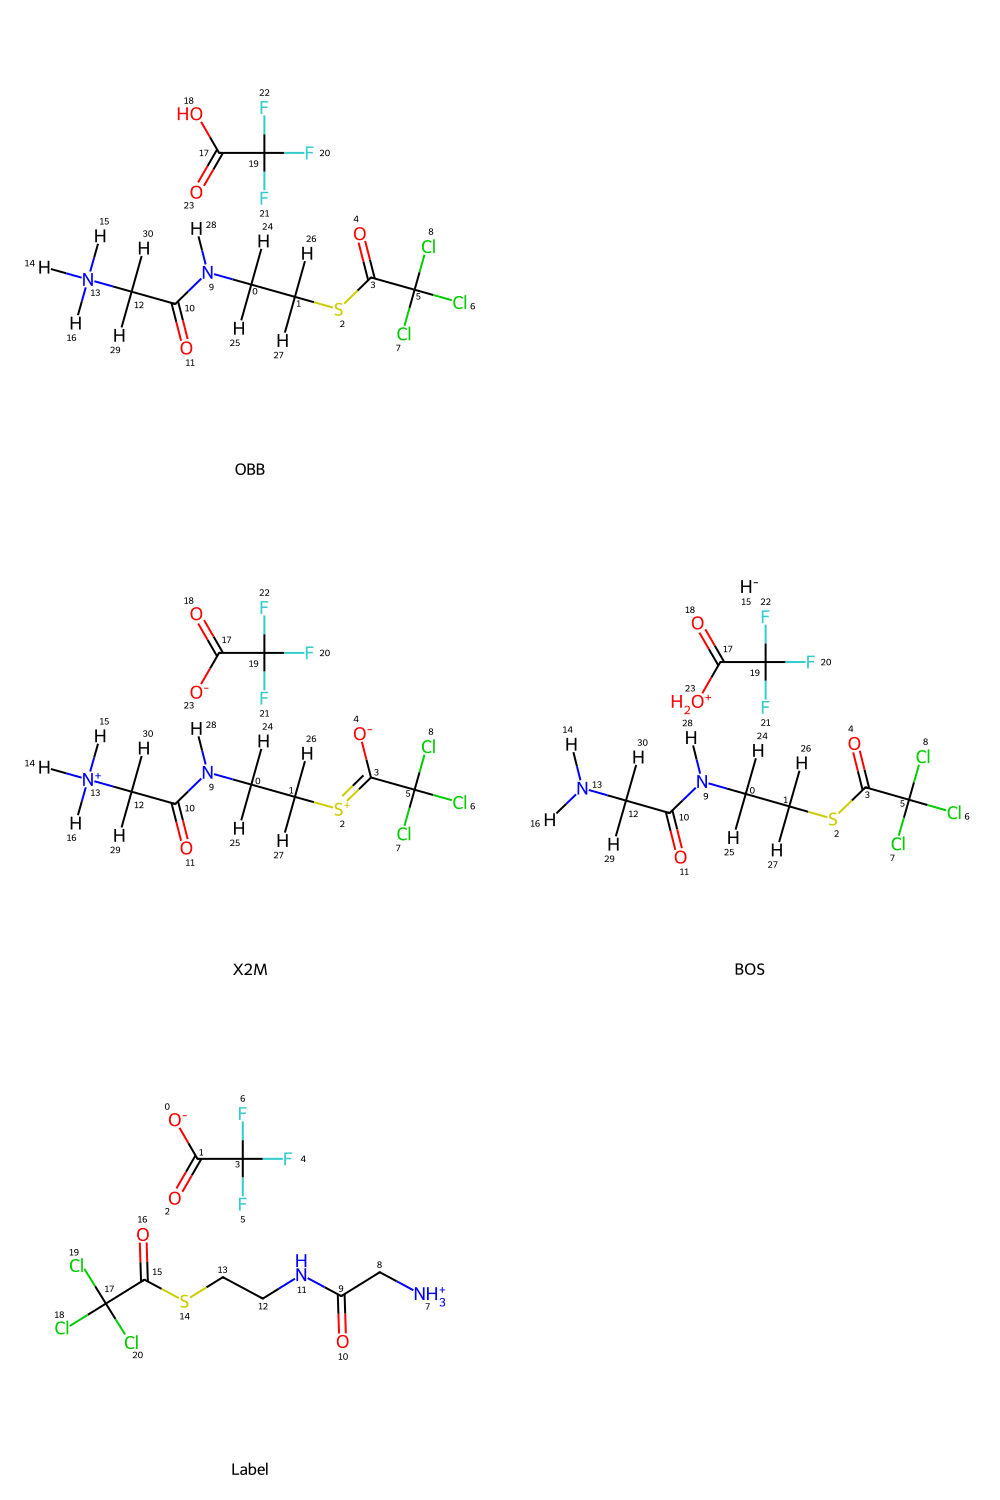

In [25]:
xyzname = '59810.xyz'
xyzfile = XYZ / xyzname
emp_obb, _ = obabel_charge(str(xyzfile.absolute()), 0)
emp_igx, _ = indigox_charge(str(xyzfile.absolute()), 0)
emp_x2m, _ = xyz2mol_charge(str(xyzfile.absolute()), 0)
emp_bos, _ = main_charge(str(xyzfile.absolute()), 0) # problem in connectivity perception; see the next cell
smi = subprocess.check_output(f"grep '/{xyzname}' '{LAB}' | cut -d' ' -f3", shell=True).decode().strip().strip('"')
emp_lab = Chem.MolFromSmiles(smi)
show_label_and_four(emp_obb, emp_igx, emp_x2m, emp_bos, emp_lab, removeHs=False)

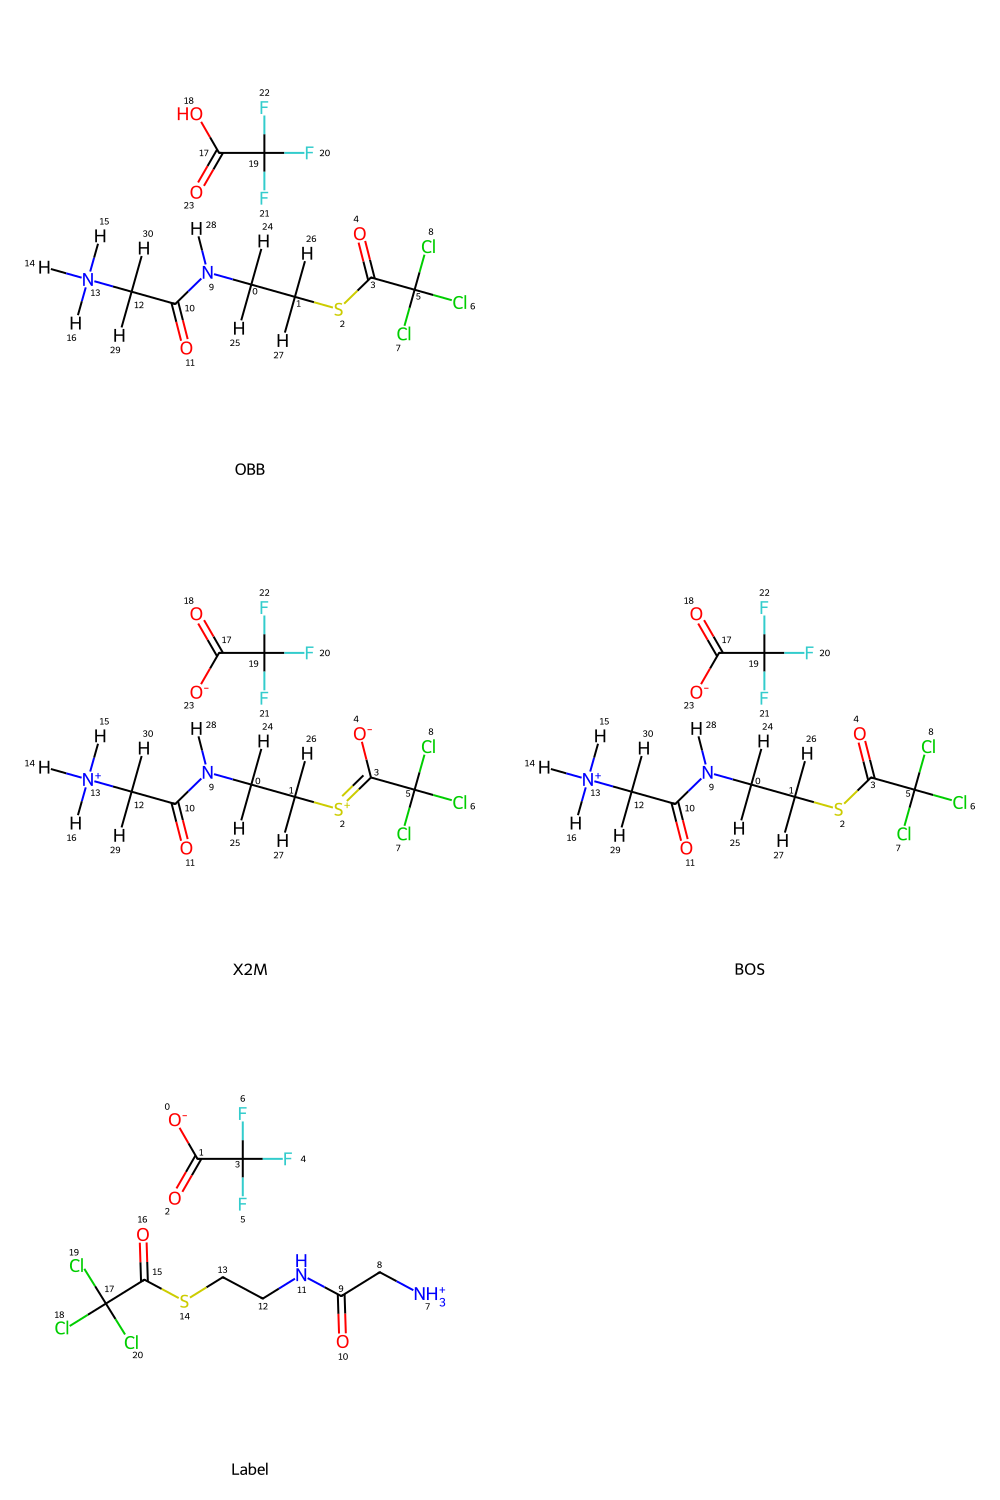

In [27]:
from BOSolver import bosolve

emp_bos2 = Chem.MolFromXYZFile(str(xyzfile.absolute()))
algo = bosolve.CovalentRadius(relTol=1.2, absTol=0.0) # relTol=1.15 for the experiment

emp_bos2 = bosolve.perceiveConn(emp_bos2, algo)
emp_bos2 = bosolve.assignBO(emp_bos2, 0) # now it works
do_stuff(emp_bos2)


show_label_and_four(emp_obb, emp_igx, emp_x2m, emp_bos2, emp_lab, removeHs=False)